# `rioxarray`

In this lesson we will introduce [`rioxarray`](https://corteva.github.io/rioxarray/stable/), a Python extension for `xarray` to manipulate `xarray.DataArray`s as rasters. 

The name `rioxarray` stands for *raster input/output + xarray*. 

## About the data
The raster files we will use today come from the [US National Agriculture Imagery Program (NAIP)](https://naip-usdaonline.hub.arcgis.com). 
NAIP images are are high-resolution aerial images with four spectral bands: red (R), green (G), blue (B) and near-infrared (NIR). 
The raster's we'll use today are from 2020.

The data used in this lesson was pre-processing from a complete NAIP scene to separate the RGB bands from the NIR band and reduce the spatial extent. 
The data was accessed through [Microsoft's Planetary Computer NAIP data repository](https://planetarycomputer.microsoft.com/dataset/naip#overview).

## Import a TIF file

Let's start by loading the libraries we will use: 

In [1]:
import os 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import geopandas as gpd 
import rioxarray as rioxr 

There are [multiple ways of opening a TIF file using `xarray` or `rioxarray`](https://corteva.github.io/rioxarray/html/getting_started/getting_started.html). 
Using the `rioxarray.open_rasterio()` function to open the TIF file is a simple way to import the raster file as an `xarray.DataArray` and make sure all our geospatial data gets loaded correctly:

In [3]:
# Import NIR TIF file
root = os.path.join('/',
                  'courses',
                  'EDS220',
                  'data',
                  'rioxarray_lesson_data')
fp = os.path.join(root, 
                 'NAIP_SB_nir.tif')

nir = rioxr.open_rasterio(fp)
nir

<xarray.DataArray (band: 1, y: 3208, x: 2419)> Size: 8MB
[7760152 values with dtype=uint8]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

Notice we see all the components of an xarray.DataArray: its dimensions (band, y, x), the coordiantes for each dimension, and some attributes. We can also directly access some of these attribues:

In [4]:
print('Shape: ', nir.shape)
print('Data Type: ', nir.dtype)

Shape:  (1, 3208, 2419)
Data Type:  uint8


`uint8` = one of the smallest number data types for python = unsigned intergers with 8 bits. It is used to represent numbers from 0 to 254 

We can access the underlying `numpy.array` holding the values of the variable.

In [5]:
print(type(nir.values))
nir.values

<class 'numpy.ndarray'>


array([[[167, 164, 161, ..., 147, 152, 151],
        [170, 170, 168, ..., 151, 149, 154],
        [176, 177, 177, ..., 151, 151, 151],
        ...,
        [ 94,  88, 101, ...,  83,  88,  79],
        [108,  95, 103, ...,  92,  91,  75],
        [ 94,  90, 104, ...,  87,  88,  82]]], dtype=uint8)

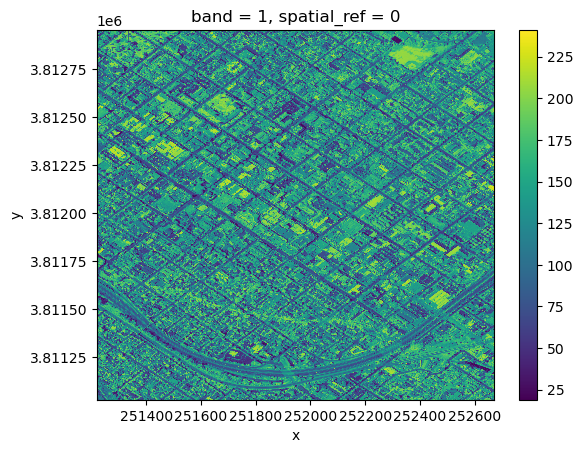

In [6]:
# Plot the raster 
nir.plot()

## Drop a dimension
Notice that our raster has an unnecessary extra dimension: band.

In [7]:
print('Size of dimensions: ', dict(nir.sizes))

Size of dimensions:  {'band': 1, 'y': 3208, 'x': 2419}


This is making this `xarray.DataArray` three-dimensional when it is not needed. We can “squeeze this dimension” of length 1 by:

1. using the `squeeze()` method. If we don’t pass any parameters, then squeeze() gets rid of all dimensions with length one, and then

2. getting rid of the associated coordinates for this dimension. We can do this using the `xarray.DataArray drop()` method and specifying the name of the coordinates we want to remove, in this case ‘band’.

In [8]:
# Original dimensions and coordinates 
print(nir.dims, nir.coords)

('band', 'y', 'x') Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0


In [9]:
# Remove length 1 dimension (band)
nir = nir.squeeze()
print(nir.dims, nir.coords)

('y', 'x') Coordinates:
    band         int64 8B 1
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0


In [10]:
# Remove coordinates associated with band dimension
nir = nir.drop_vars('band')
print(nir.dims, nir.coords)

('y', 'x') Coordinates:
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0


## `rio` accessor 

Use the `rio` accessor for an `xarray.DataArray` to access its raster properties:

In [11]:
print('Number of bands: ', nir.rio.count)
print('Height: ', nir.rio.height)
print('Width: ', nir.rio.width)
print('Spatial bounding box:')
print(nir.rio.bounds(), '\n')
print('CRS: ', nir.rio.crs)

Number of bands:  1
Height:  3208
Width:  2419
Spatial bounding box:
(251218.8, 3811027.2, 252670.19999999998, 3812952.0) 

CRS:  EPSG:26911


## Multi-band raster
Let’s now import the RGB raster:

In [12]:
# Import RGB raster 
fp = os.path.join(root, 'NAIP_SB_rgb.tif')
rgb = rioxr.open_rasterio(fp)
rgb

<xarray.DataArray (band: 3, y: 3208, x: 2419)> Size: 23MB
[23280456 values with dtype=uint8]
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

Since this raster has three bands we can plot it as imagae using the `.plot.imshow()` method which will interpret the three bands of the object as RGB bands. 

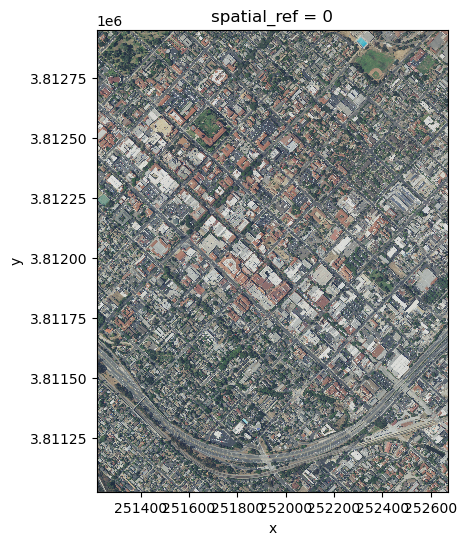

In [15]:
# Plot three bands as RGB image
rgb_aspect_ratio = rgb.rio.width / rgb.rio.height  # Raster's aspect ratio
rgb.plot.imshow(size=6,  # Plot's height in inches
                aspect=rgb_aspect_ratio  # Ratio of width/height
                )

## Clip a raster 

Our area of interest for this lesson is a smaller region including a few blocks around NCEAS. This area is already outlined in a GeoJSON file: 

<Axes: >

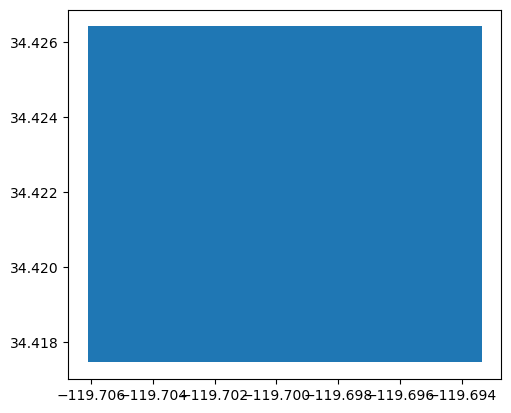

In [16]:
fp = os.path.join(root, 'SB_aoi.geojson')
aoi = gpd.read_file(fp)
aoi.plot()

Remember: we need to match the CRSs everytime we work with geospatial data. 

In [17]:
# Examine CRSs
print('aoi CRS', aoi.crs)
print('nir CRS', nir.rio.crs)
print('rgb CRS', rgb.rio.crs)

aoi CRS EPSG:4326
nir CRS EPSG:26911
rgb CRS EPSG:26911


In [18]:
# Reproject AOI to RGB CRS
aoi = aoi.to_crs(rgb.rio.crs)
print('Matched CRS?',  aoi.crs == rgb.rio.crs)

Matched CRS? True


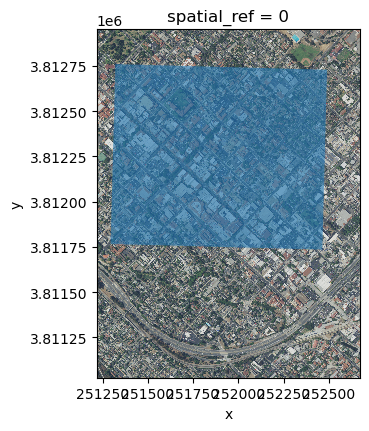

In [19]:
# Plot of RGB raster with AOI overlay
fig, ax = plt.subplots(figsize=(6, 6 * rgb_aspect_ratio))  # Directly set size and aspect
rgb.plot.imshow(ax=ax)
aoi.plot(ax=ax, alpha=0.6)
plt.show()

To clip the raster, we use the `rio.clip_box()` method: 

In [20]:
# Clip rasters to AOI 
rgb_small = rgb.rio.clip_box(*aoi.total_bounds) # Unpacks and passes it one by one into function 

In [21]:
nir_small = nir.rio.clip_box(*aoi.total_bounds)

OG shape:  (3208, 2419)
Clipped shape,  (1710, 1995)


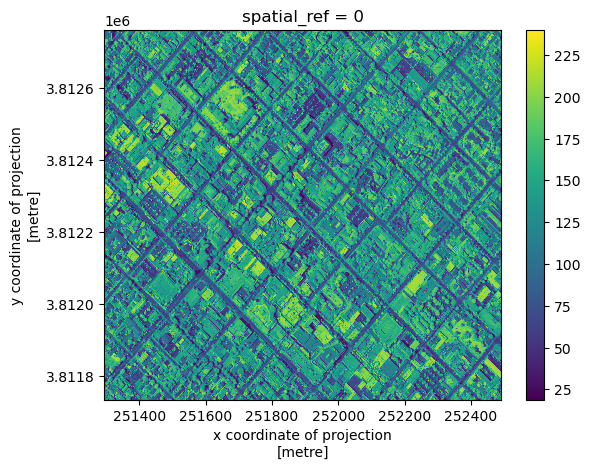

In [22]:
# Examine clipped data 
print('OG shape: ', nir.shape)
print('Clipped shape, ', nir_small.shape)
nir_small.plot()

OG shape:  (3, 3208, 2419)
Clipped shape:  (3, 1710, 1995)


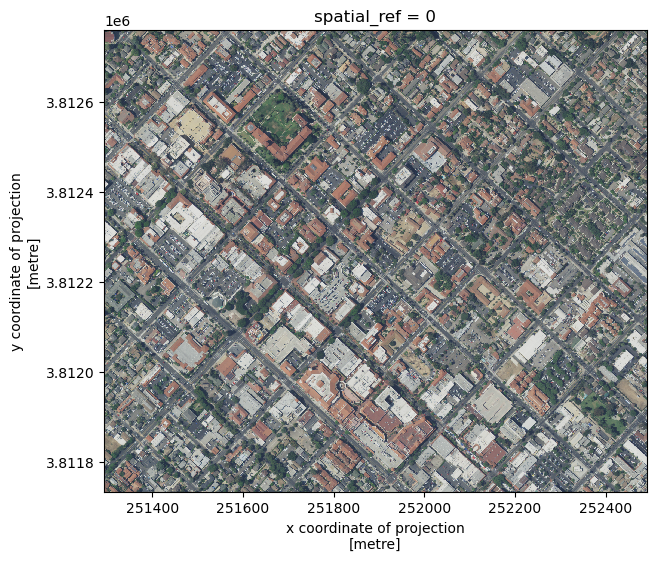

In [24]:
# Examine the clipped data 
print('OG shape: ', rgb.shape)
print('Clipped shape: ', rgb_small.shape)

# Plot with the correct size 
ratio = rgb_small.rio.width / rgb_small.rio.height
rgb_small.plot.imshow(size=6,  # Plot's height in inches
                aspect=ratio  # Ratio of width/height
                )

## Raster algebra 

In our case, we are interested in computed the normalized difference vegetation index (NDVI). NDVI is an index commonly used to check if an area has live green vegetation or not. 

- NDVI calculation ranges from -1 to 1 
- negative values are usually water, impervious surfaces, rocks, snow, clouds 
- Bare soil = 0.1-0.2 range 
- Plants are always positive between 0.2 and 1 

Formula for NDVI is

$NDVI = \frac{NIR - RED}{NIR + RED}$

In [25]:
# Select the red band by using the dimension name and coordinate by label 
red = rgb_small.sel(band=1)

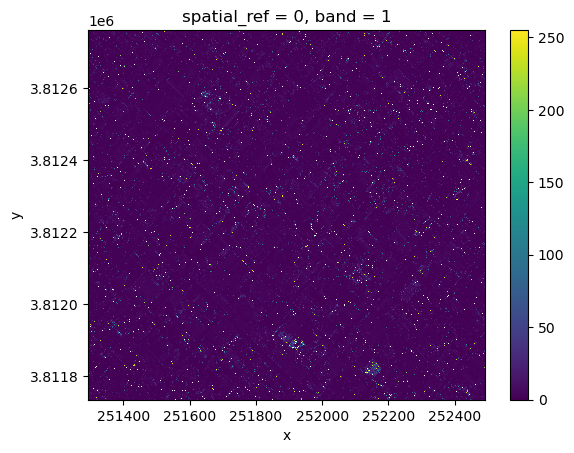

In [26]:
ndvi = (nir - red)/(nir + red)
ndvi.plot()

## Data type issues

The uint8 (8-bit unsigned integer) is a very small data type that only holds integers from 0 up to 255. In particular, calculations don’t return what what we are used to when working with intgers (they’re done module 256):

In the NDVI formula we have to add NIR + Red. If both NIR and Red are very close to 255, when we add them, the calculation overflows the uint8 data type and we don’t get the expected results.

## Updating data types

To be able to perform the calculation successfully, we will need to udpate the data type of our rasters into int16, which will be big enough to hold all the numbers that appear in the calculations:



In [27]:
# Update data type to int16 to perform NDVI calculation 
red16 = red.astype('int16')
nir16 = nir_small.astype('int16')

print(red16.dtype)
print(nir16.dtype)

int16
int16


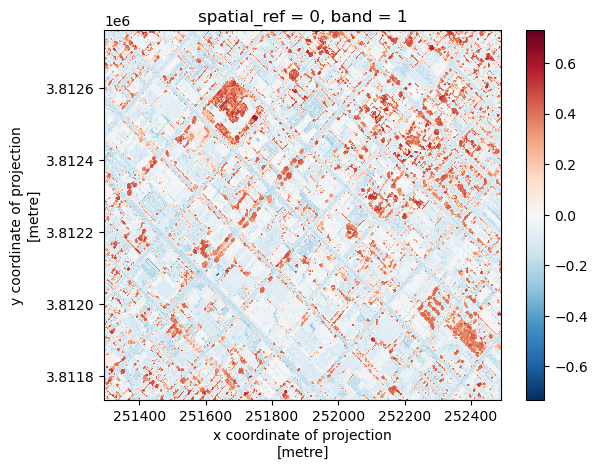

In [28]:
# Calculate NDVI 
ndvi = (nir16 - red16)/(nir16 + red16)
ndvi.plot()